# Ce notebook servira de baseline pour le modèle de classification VGG16

## 1- Importations

In [ ]:
!pip install scikit-learn
!pip install h5py


In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
import h5py

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix  # Importation de confusion_matrix
import seaborn as sns  # Importation de seaborn
from sklearn.utils import shuffle  # Importation pour mélanger les données
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report



print(tf.__version__)

2025-05-06 12:54:07.562385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746536047.795485      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746536047.861622      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0


## 2- Acquisition des images


In [3]:
import os
import pandas as pd
from tensorflow.keras.preprocessing import image
import numpy as np

# Chemins vers les fichiers
csv_file = '/kaggle/input/aptos-mini/train_images.csv'
image_dir = '/kaggle/input/aptos-mini/train_images'

# Charger le CSV contenant les labels
df = pd.read_csv(csv_file)

# Vérifier qu'il y a bien 5 classes
if df['diagnosis'].nunique() != 5:
    raise ValueError("Le dataset doit contenir exactement 5 classes.")

# Initialiser les listes d'images et de labels
images = []
labels = []

# Parcourir chaque ligne du CSV pour charger les images et les labels
for _, row in df.iterrows():
    image_id = row['id_code']
    label = row['diagnosis']
    
    img_path = os.path.join(image_dir, image_id + '.png')
    
    if os.path.exists(img_path):
        img = image.load_img(img_path, target_size=(128, 128), color_mode="grayscale")
        img_array = image.img_to_array(img)
        images.append(img_array)
        labels.append(label)

# Convertir en tableaux numpy pour l'entraînement
images = np.array(images)
labels = np.array(labels)


In [4]:
from sklearn.utils import shuffle


# Normalisation des images entre 0 et 1
images = images / 255.0


# Mélange aléatoire
images, labels = shuffle(images, labels, random_state=42)

# Split manuel 80/20
train_size = int(0.8 * len(images))
train_images, test_images = images[:train_size], images[train_size:]
train_labels, test_labels = labels[:train_size], labels[train_size:]

# Affichage des formes
print('Train images shape:', train_images.shape)
print('Test images shape:', test_images.shape)
print('Train labels shape:', train_labels.shape)
print('Test labels shape:', test_labels.shape)

Train images shape: (400, 128, 128, 1)
Test images shape: (100, 128, 128, 1)
Train labels shape: (400,)
Test labels shape: (100,)


## 3- Verification de la distribution des labels

In [46]:
import os
import pandas as pd

# CSV and image directory paths
csv_path = '/kaggle/input/aptos-mini/train_images.csv'          
images_dir = '/kaggle/input/aptos-mini/train_images'       

# Load CSV
df = pd.read_csv(csv_path)
print("Columns in CSV:", df.columns.tolist())  # Helps debug

# Rename columns if necessary
if 'id_code' in df.columns and 'diagnosis' in df.columns:
    df.rename(columns={'id_code': 'filename', 'diagnosis': 'label'}, inplace=True)

# Append .png extension if needed
if not df['filename'].iloc[0].endswith('.png'):
    df['filename'] = df['filename'] + '.png'

# Optional: Check if image files exist
df['exists'] = df['filename'].apply(lambda x: os.path.isfile(os.path.join(images_dir, x)))
missing = df[~df['exists']]
if not missing.empty:
    print(f"\nMissing files ({len(missing)}):")
    print(missing[['filename', 'label']])

# Count valid PNG files per class
df_valid = df[df['exists']]
class_counts = df_valid['label'].value_counts()

# Print the result
print("\nNumber of PNG files per class:")
for label, count in class_counts.items():
    print(f"Class: {label}, Count: {count}")


Columns in CSV: ['id_code', 'diagnosis']

Number of PNG files per class:
Class: 2, Count: 100
Class: 4, Count: 100
Class: 1, Count: 100
Class: 0, Count: 100
Class: 3, Count: 100


## 4- Initialisation du modèle

In [5]:
# Création du modèle CNN
model = tf.keras.Sequential([
    # Couches de convolution pour extraire les caractéristiques des images
    tf.keras.layers.Reshape(target_shape=(128, 128, 1), input_shape=(128, 128, 1)),  # Assurer que la forme d'entrée est correcte
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')  # Adapté au nombre de classes
])

# Compilation du modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'] )



# Entraînement du modèle et récupération de l'historique
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

# Récupération des valeurs d'historique
history_dict = history.history



/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1746536115.784058      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/10


I0000 00:00:1746536118.998664     104 service.cc:148] XLA service 0x7d216400a890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746536118.999462     104 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746536119.244265     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


 7/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2209 - loss: 1.8722

I0000 00:00:1746536121.572156     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - accuracy: 0.2519 - loss: 1.7783 - val_accuracy: 0.5400 - val_loss: 1.3515
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4948 - loss: 1.3009 - val_accuracy: 0.4600 - val_loss: 1.2665
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5304 - loss: 1.1783 - val_accuracy: 0.5400 - val_loss: 1.1529
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5016 - loss: 1.1855 - val_accuracy: 0.5000 - val_loss: 1.1878
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5527 - loss: 1.0995 - val_accuracy: 0.4700 - val_loss: 1.2217
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6295 - loss: 0.9975 - val_accuracy: 0.4500 - val_loss: 1.3176
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6604 - loss: 0.9529 - val_accuracy: 0.4300 - val_loss: 1.1446
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6794 - loss: 0.9060 - val_accuracy: 0.4800 - val_loss: 1

## 5- Calcul des métriques

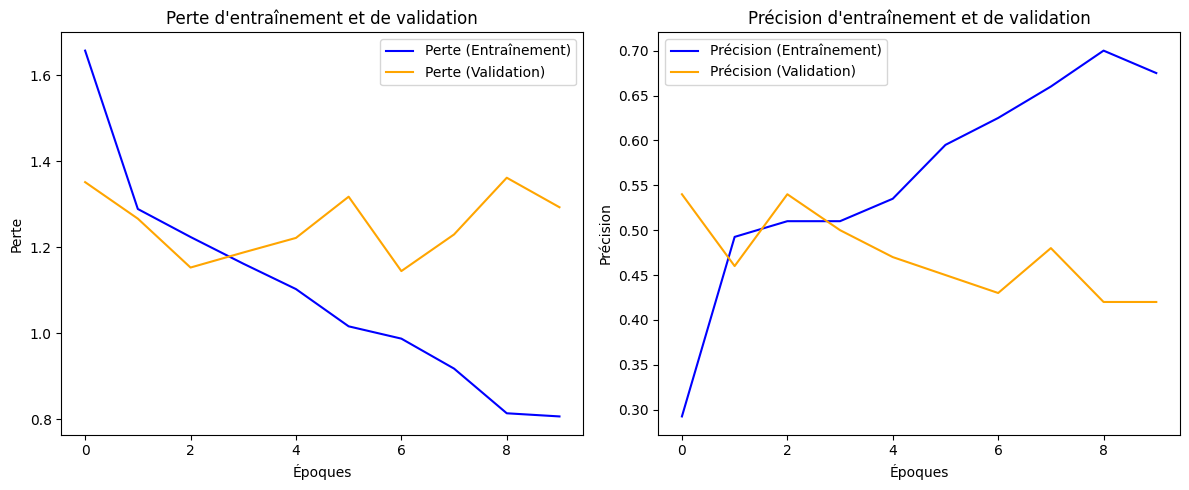

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Classes uniques des prédictions: [0 1 2 3 4]
Classes uniques des labels réels: [0 1 2 3 4]
Dimensions de predicted_labels: (100,)
Dimensions de true_labels: (100,)


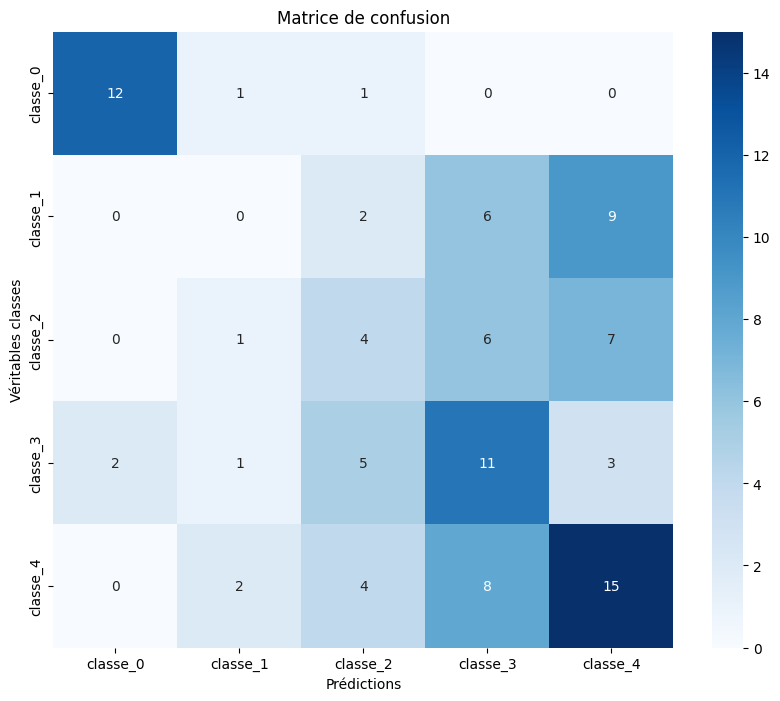

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Supposons que vous avez déjà ces variables :
# - `history_dict` : historique d'entraînement avec les pertes et précisions
# - `model` : votre modèle de machine learning entraîné
# - `test_images` : les images de test
# - `test_labels` : les labels de test
# - `class_names` : les noms des classes



class_names = ['classe_0', 'classe_1', 'classe_2', 'classe_3', 'classe_4']

# Affichage des courbes de perte et de précision
plt.figure(figsize=(12, 5))

# Perte d'entraînement et validation
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Perte (Entraînement)', color='blue')
plt.plot(history_dict['val_loss'], label='Perte (Validation)', color='orange')  # Ajouter la courbe de validation
plt.title('Perte d\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

# Précision d'entraînement et validation
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Précision (Entraînement)', color='blue')
plt.plot(history_dict['val_accuracy'], label='Précision (Validation)', color='orange')  # Ajouter la courbe de validation
plt.title('Précision d\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.tight_layout()
plt.savefig('/kaggle/working/precision.svg', format='svg')
plt.savefig('/kaggle/working/precision.png', format='png')
plt.show()

# Faire des prédictions sur l'ensemble de test
predictions = model.predict(test_images)

# Convertir les prédictions en classes (en utilisant argmax)
predicted_labels = np.argmax(predictions, axis=1)

# Si test_labels sont déjà sous forme d'indices, vous pouvez les utiliser directement
true_labels = test_labels  # Pas besoin d'appliquer np.argmax ici

# Vérification des classes uniques dans les labels
print(f"Classes uniques des prédictions: {np.unique(predicted_labels)}")
print(f"Classes uniques des labels réels: {np.unique(true_labels)}")

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Vérification des dimensions des labels
print(f"Dimensions de predicted_labels: {predicted_labels.shape}")
print(f"Dimensions de true_labels: {true_labels.shape}")

# Affichage de la matrice de confusion avec un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Véritables classes')
plt.savefig("/kaggle/working/confusion_matrix.svg", format='svg')
plt.savefig("/kaggle/working/confusion_matrix.png", format='png')
plt.show()


## 6- AUC et ROC !!!

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Predictions shape (after prediction): (100, 5)
test_labels shape: (100,)
y_true shape: (100,)
y_scores shape: (100, 5)
y_true_bin shape: (100, 5)
Calcul des courbes ROC pour la classe 0...
Calcul des courbes ROC pour la classe 1...
Calcul des courbes ROC pour la classe 2...
Calcul des courbes ROC pour la classe 3...
Calcul des courbes ROC pour la classe 4...


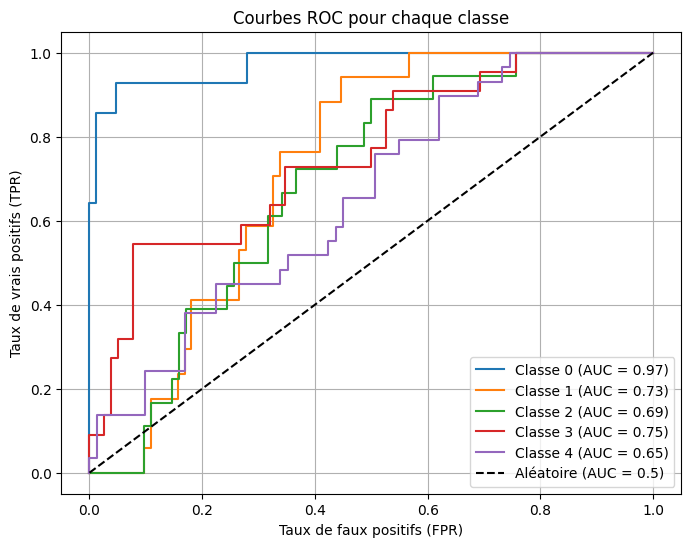

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# Faire des prédictions sur l'ensemble de test
predictions = model.predict(test_images)  # Prédiction sur toutes les images
print("Predictions shape (after prediction):", predictions.shape)

# Vérifier les dimensions de test_labels et les convertir en un format binaire
print("test_labels shape:", test_labels.shape)

# Si test_labels sont déjà sous forme d'indices de classes (non one-hot), vous n'avez pas besoin de np.argmax
y_true = test_labels  # Directement utiliser test_labels si ce sont des indices de classe
y_scores = predictions  # Les scores de toutes les classes

# Vérification des formes de y_true et y_scores
print("y_true shape:", y_true.shape)
print("y_scores shape:", y_scores.shape)

# Convertir les labels en format binaire (one-vs-rest) pour le calcul de la courbe ROC
n_classes = y_scores.shape[1]  # Le nombre de classes
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Vérification des dimensions après la conversion en binaire
print("y_true_bin shape:", y_true_bin.shape)

# Calculer la courbe ROC et AUC pour chaque classe
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    print(f"Calcul des courbes ROC pour la classe {i}...")
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_scores[:, i])

# Tracer la courbe ROC pour chaque classe
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire (AUC = 0.5)')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbes ROC pour chaque classe')
plt.legend(loc='lower right')
plt.grid(True)

# Sauvegarder les graphiques
plt.savefig('/kaggle/working/roc_auc_multiclass.svg', format='svg')
plt.savefig('/kaggle/working/roc_auc_multiclass.png', format='png')

# Afficher la courbe ROC
plt.show()


## 7- Apeçu des images du dataset avec leurs labels

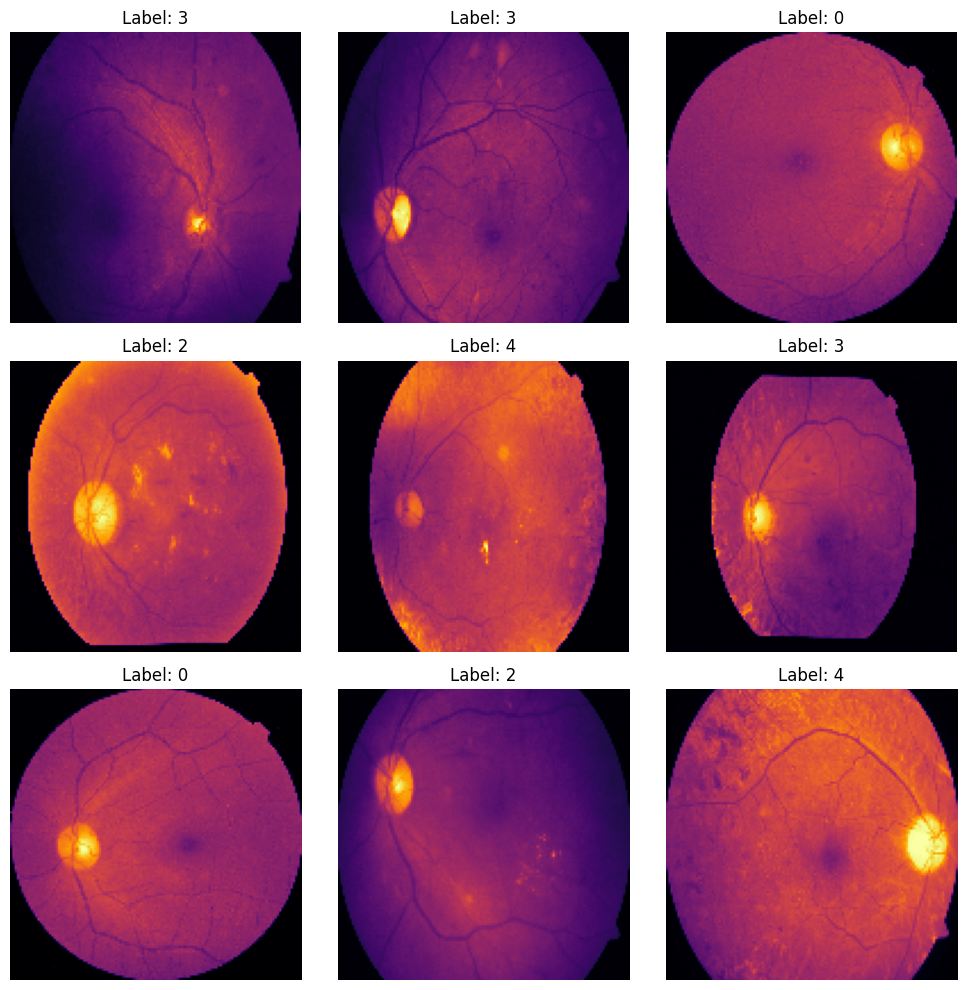

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Mélange aléatoire des indices
indices = np.random.permutation(len(images))

# Affichage de 9 images mélangées avec leurs labels
plt.figure(figsize=(10, 10))
for i in range(9):
    idx = indices[i]
    plt.subplot(3, 3, i + 1)

    plt.imshow(images[idx],cmap='inferno')  #cmap='gray' cmap='magma
    
    #https://matplotlib.org/stable/users/explain/colors/colormaps.html

    # Affichage du label
    label = np.argmax(labels[idx]) if len(labels[idx].shape) > 0 else labels[idx]

    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [30]:
print("test_labels shape:", test_labels.shape)
print("predictions shape:", predictions.shape)


test_labels shape: (100,)
predictions shape: (100, 5)


In [31]:
print(f'classe names: {class_names}')

classe names: ['classe_0', 'classe_1', 'classe_2', 'classe_3', 'classe_4']


## 8- Sauvegarde modèle pre-entrainé

In [33]:
# Sauvegarder le modèle et ses poids dans un fichier .h5
model.save('mon_modele128.h5')

model.save("/kaggle/working/mon_modele128.h5")
print("Modèle et poids sauvegardés dans 'mon_modele128.h5'")

Modèle et poids sauvegardés dans 'mon_modele128.h5'


## 9- Inspecter le modèle entrainé

In [34]:
# Charger le fichier .h5
file_path = '/kaggle/working/mon_modele128.h5'  # Remplacez par le chemin de votre fichier .h5
with h5py.File(file_path, 'r') as file:
    # Afficher la liste des groupes et datasets dans le fichier
    print("Liste des objets dans le fichier .h5:")
    file.visititems(lambda name, obj: print(name, obj))

    print("__________________________________________________________________________________________________________________________________ \n")

    # Si vous voulez explorer l'architecture du modèle :
    print("\nClés du modèle sauvegardé:")
    for key in file.keys():
        print(key)

    print("__________________________________________________________________________________________________________________________________ \n")

from tensorflow.keras.models import load_model

# Charger le modèle depuis le fichier .h5
model = load_model('mon_modele128.h5')

# Afficher l'architecture du modèle

print("Architecture du modèle :")
model.summary()

print("__________________________________________________________________________________________________________________________________ \n")


# Inspecter les poids de chaque couche
for layer in model.layers:
    weights = layer.get_weights()
    print(f"Poids pour la couche {layer.name}: {weights}")


Liste des objets dans le fichier .h5:
model_weights <HDF5 group "/model_weights" (9 members)>
model_weights/conv2d <HDF5 group "/model_weights/conv2d" (1 members)>
model_weights/conv2d/sequential <HDF5 group "/model_weights/conv2d/sequential" (1 members)>
model_weights/conv2d/sequential/conv2d <HDF5 group "/model_weights/conv2d/sequential/conv2d" (2 members)>
model_weights/conv2d/sequential/conv2d/bias <HDF5 dataset "bias": shape (32,), type "<f4">
model_weights/conv2d/sequential/conv2d/kernel <HDF5 dataset "kernel": shape (3, 3, 1, 32), type "<f4">
model_weights/conv2d_1 <HDF5 group "/model_weights/conv2d_1" (1 members)>
model_weights/conv2d_1/sequential <HDF5 group "/model_weights/conv2d_1/sequential" (1 members)>
model_weights/conv2d_1/sequential/conv2d_1 <HDF5 group "/model_weights/conv2d_1/sequential/conv2d_1" (2 members)>
model_weights/conv2d_1/sequential/conv2d_1/bias <HDF5 dataset "bias": shape (64,), type "<f4">
model_weights/conv2d_1/sequential/conv2d_1/kernel <HDF5 dataset "

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,391 (28.20 MB)

 Trainable params: 7,392,389 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

__________________________________________________________________________________________________________________________________ 

Poids pour la couche reshape: []
Poids pour la couche conv2d: [array([[[[ 0.00317333, -0.09989667,  0.05308226,  0.04275168,
          -0.09331767,  0.07662454,  0.10256877,  0.02880675,
           0.0325219 , -0.00343065,  0.06678714,  0.13884962,
          -0.08122338,  0.07380261,  0.02285851,  0.08250288,
           0.04092974,  0.10751728,  0.03043875,  0.11597445,
          -0.06089147, -0.06510269,  0.00616392, -0.01022947,
           0.11101226, -0.08970028,  0.08015665, -0.0402476 ,
          -0.11700482, -0.10976318,  0.05532936, -0.1391919 ]],

        [[ 0.02403471,  0.04753516, -0.01838694, -0.00976631,
           0.12046459,  0.0123713 , -0.12586568, -0.0953216 ,
           0.01333851, -0.12042705,  0.14477046, -0.08466591,
          -0.00418748,  0.15511674, -0.13314585,  0.05311837,
           0.02202468,  0.03171442, -0.08206484,  0.01334

## 10- Visualisation du modèle pré-entrainé

In [35]:
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

# Path to your .h5 model
model_path = '/kaggle/working/mon_modele128.h5'  

# Ensure the file exists
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at: {model_path}")

# Load the Keras model
model = load_model(model_path)

# Print model summary (textual representation)
print("Model Summary:")
model.summary()

# Save architecture as an image
plot_file = '/kaggle/working/mon_modele128_architecture.png'
plot_model(model, to_file=plot_file, show_shapes=True, show_layer_names=True)

print(f"Model architecture saved as {plot_file}")


Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,391 (28.20 MB)

 Trainable params: 7,392,389 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Model architecture saved as /kaggle/working/mon_modele128_architecture.png


## 11- Inference avec un modèle pré-entrainé

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
Classe prédite: classe_3


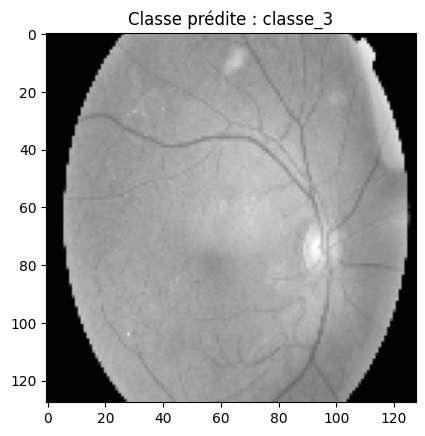

In [37]:
# Charger le modèle pré-entraîné depuis le fichier .h5
model = load_model('/kaggle/working/mon_modele128.h5')  # Remplacez 'mon_modele.h5' par le chemin de votre modèle

# Liste des noms de classes, dans le même ordre que lors de l'entraînement
class_names = ['classe_0','classe_1','classe_2','classe_3','classe_4']  # Remplacez par les noms réels des classes (doivent être dans le même ordre que dans l'entraînement)

# Charger une image de test (assurez-vous que l'image est bien dans le format attendu par le modèle)
img_path = '/kaggle/input/aptos2019-blindness-detection/train_images/00e4ddff966a.png'  # Remplacez par le chemin de votre image
img = image.load_img(img_path, target_size=(128, 128), color_mode="grayscale")  # Taille d'entrée du modèle

# Convertir l'image en tableau numpy
img_array = image.img_to_array(img)

# Normalisation de l'image (comme fait pendant l'entraînement)
img_array = img_array / 255.0  # Normalisation entre 0 et 1

# Ajouter une dimension supplémentaire pour avoir la forme (1, 28, 28, 1) - batch size de 1
img_array = np.expand_dims(img_array, axis=0)

# Faire l'inférence (prédiction) sur l'image
predictions = model.predict(img_array)

# Convertir les prédictions en classe (la classe avec la probabilité la plus élevée)
predicted_class_index = np.argmax(predictions, axis=1)

# Trouver le nom de la classe prédite en utilisant l'indice
predicted_class_name = class_names[predicted_class_index[0]]

# Afficher la classe prédite
print("Classe prédite:", predicted_class_name)

# Optionnel : Afficher l'image de test
plt.imshow(img, cmap='gray')
plt.title(f"Classe prédite : {predicted_class_name}")
plt.show()


## Affichage des couches cachées

In [ ]:
def display_all_layers(model, prefix=''):
    for i, layer in enumerate(model.layers):
        print(f"{prefix}[{i}] {layer.name} --- {layer.__class__.__name__}")
        if isinstance(layer, tf.keras.Model):
            display_all_layers(layer, prefix + '  ')

## TEST GRADCAM !!!!

Forme de l'entrée de l'image : (1, 128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
Prédictions pour l'image : [0.00469276 0.18085839 0.17718038 0.22945835 0.4078101 ] 


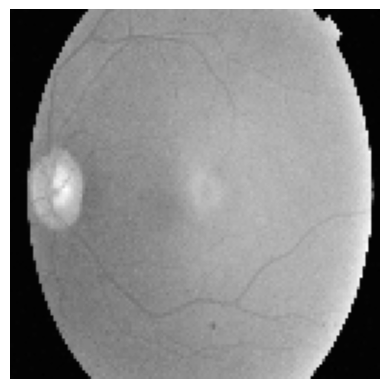

Couches du modèle :

Noms des couches du modèle chargé depuis : /kaggle/working/mon_modele128.h5
[0] : reshape--- keras_tensor_1569---<Reshape name=reshape, built=True>
[1] : conv2d--- keras_tensor_1571---<Conv2D name=conv2d, built=True>
[2] : max_pooling2d--- keras_tensor_1574---<MaxPooling2D name=max_pooling2d, built=True>
[3] : conv2d_1--- keras_tensor_1578---<Conv2D name=conv2d_1, built=True>
[4] : max_pooling2d_1--- keras_tensor_1583---<MaxPooling2D name=max_pooling2d_1, built=True>
[5] : flatten--- keras_tensor_1589---<Flatten name=flatten, built=True>
[6] : dense--- keras_tensor_1596---<Dense name=dense, built=True>
[7] : dense_1--- keras_tensor_1604---<Dense name=dense_1, built=True>
Structure complète du modèle :
[0] reshape --- Reshape
[1] conv2d --- Conv2D
[2] max_pooling2d --- MaxPooling2D
[3] conv2d_1 --- Conv2D
[4] max_pooling2d_1 --- MaxPooling2D
[5] flatten --- Flatten
[6] dense --- Dense
[7] dense_1 --- Dense


ValueError: The layer sequential has never been called and thus has no defined input.

In [71]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
import cv2

img_size = (128, 128)  # Taille de l'image attendue par le modèle

# Fonction pour afficher toutes les couches du modèle
def display_all_layers(model, prefix=''):
    for i, layer in enumerate(model.layers):
        print(f"{prefix}[{i}] {layer.name} --- {layer.__class__.__name__}")
        if isinstance(layer, tf.keras.Model):
            display_all_layers(layer, prefix + '  ')

# Fonction pour afficher les noms des couches du modèle
def display_layer_names(model_path):
    try:
        model = load_model(model_path)
        print(f"Noms des couches du modèle chargé depuis : {model_path}")
        for i, layer in enumerate(model.layers):
            print(f"[{i}] : {layer.name}--- {layer.output.name}---{layer}")
    except FileNotFoundError:
        print(f"Erreur: Le fichier de modèle au chemin '{model_path}' n'a pas été trouvé.")
    except Exception as e:
        print(f"Erreur lors du chargement du modèle: {e}")

# Fonction pour générer une carte Grad-CAM
def make_gradcam_heatmap(img_path, model, last_conv_layer_name='block5_conv3', img_size=(128, 128)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    try:
        base_model = model.get_layer('vgg16')
        conv_layer = base_model.get_layer(last_conv_layer_name).output
        grad_model = Model(inputs=base_model.input, outputs=[conv_layer, base_model.output])
    except ValueError:
        conv_layer = model.get_layer(last_conv_layer_name).output
        grad_model = Model(inputs=model.input, outputs=[conv_layer, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if len(predictions.shape) == 2:
            pred_index = tf.argmax(predictions[0])
            loss = predictions[:, pred_index]
        else:
            loss = tf.reduce_mean(predictions)

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    img_rgb = tf.keras.preprocessing.image.array_to_img(img_array[0])
    return heatmap.numpy(), np.array(img_rgb)

# Fonction pour afficher la carte Grad-CAM sur l'image
def show_gradcam(img_path, model, last_conv_layer_name='block5_conv3', img_size=(128, 128), alpha=0.4):
    heatmap, original_img = make_gradcam_heatmap(img_path, model, last_conv_layer_name, img_size)

    # Resize heatmap to match image
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

    # Superimpose heatmap onto image
    superimposed_img = cv2.addWeighted(original_img, 1 - alpha, heatmap_colored, alpha, 0)

    # Affichage avec colorbar réelle (image séparée pour la légende)
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(superimposed_img[..., ::-1])
    ax.axis('off')
    ax.set_title(f"Grad-CAM: {last_conv_layer_name}")

    # Créer une image fictive pour la colorbar avec les bonnes valeurs de heatmap
    cbar_img = ax.imshow(heatmap_resized, cmap='jet', alpha=1.0, visible=False)  # cachée mais valeurs réelles

    # Ajouter colorbar correctement
    cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
    fig.colorbar(cbar_img, cax=cax)
    plt.tight_layout()

    plt.savefig("/kaggle/working/gradcam_result.png")
    plt.show()

# Fonction pour afficher et sauvegarder la carte Grad-CAM filtrée
def display_gradcam_filtered(img_path, model, last_conv_layer_name='block5_conv3', threshold=0.6, img_size=(224, 224)):
    # Générer heatmap avec ta fonction existante
    heatmap, _ = make_gradcam_heatmap(img_path, model, last_conv_layer_name, img_size)

    # Charger image d’origine (pour dimensions)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Redimensionner heatmap à la taille de l’image
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Appliquer un masque basé sur le seuil
    mask = heatmap_resized >= threshold
    masked_heatmap = np.zeros_like(heatmap_resized)
    masked_heatmap[mask] = heatmap_resized[mask]

    # Affichage et sauvegarde avec colorbar visible
    plt.figure(figsize=(8, 8))
    img_display = plt.imshow(masked_heatmap, cmap='jet')
    plt.colorbar(img_display, label='Importance relative')
    plt.title(f"Zones fortement activées (seuil: {int(threshold * 100)}%)")
    plt.axis('off')

    os.makedirs("static/img", exist_ok=True)
    plt.savefig('/kaggle/working/gradcam_filtre.png')
    plt.close()

# Fonction pour afficher les cartes d'activation
def display_activation_maps(model, img_path, layer_names, img_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)  # Ajout dimension batch
    x = preprocess_input(x)

    base_model = model.get_layer('vgg16')

    # Création du modèle pour extraire les activations
    layer_outputs = [base_model.get_layer(name).output for name in layer_names]
    activation_model = Model(inputs=base_model.input, outputs=layer_outputs)

    # Prédiction
    activations = activation_model.predict(x)

    if not isinstance(activations, list):
        activations = [activations]

    for layer_name, activation in zip(layer_names, activations):
        if len(activation.shape) != 4:
            print(f"⚠️ La couche '{layer_name}' ne retourne pas de cartes 2D (activation.shape = {activation.shape})")
            continue

        n_features = activation.shape[-1]
        size = activation.shape[1]

        n_cols = 8
        n_rows = n_features // n_cols if n_features % n_cols == 0 else (n_features // n_cols) + 1

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.5, n_rows * 1.5))
        fig.suptitle(f"Activations - Layer: {layer_name}", fontsize=16)

        if n_rows == 1:
            axes = np.expand_dims(axes, axis=0)

        for i in range(n_rows * n_cols):
            ax = axes[i // n_cols, i % n_cols]
            if i < n_features:
                ax.imshow(activation[0, :, :, i], cmap='viridis')
            ax.axis('off')

        plt.tight_layout()
        plt.savefig(f"activation_maps_{layer_name}.png")
        plt.show()

# Main code
if __name__ == '__main__':

       # Charger le modèle pré-entraîné
    model = load_model("/kaggle/working/mon_modele128.h5")
    
    # Chemin vers ton image
    img_path = '/kaggle/input/aptos-mini/train_images/0024cdab0c1e.png'
    
    # Charger l'image en niveaux de gris
    img = image.load_img(img_path, target_size=(128, 128), color_mode='grayscale')
    
    # Convertir l'image en tableau numpy
    x = image.img_to_array(img)
    
    # Ajouter une dimension pour le batch (le modèle attend une forme [batch_size, height, width, channels])
    x = np.expand_dims(x, axis=0)
    
    # Normaliser les pixels de l'image : valeurs entre 0 et 1
    x = x / 255.0
    
    # Vérifier la forme de l'entrée
    print(f'Forme de l\'entrée de l\'image : {x.shape}')
    
    # Effectuer l'inférence
    predictions = model.predict(x)
    
    # Afficher les résultats de la prédiction
    print(f'Prédictions pour l\'image : {predictions[0]} ')
    
    # Si tu veux aussi afficher l'image (optionnel)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

    # Afficher les noms des couches du modèle
    print(f'Couches du modèle :\n')
    display_layer_names("/kaggle/working/mon_modele128.h5")

    # Afficher la structure complète du modèle
    print("Structure complète du modèle :")
    display_all_layers(model)

    # Afficher les cartes d'activation pour une couche spécifique
    display_activation_maps(model, img_path, ['block3_conv3'])

    # Afficher Grad-CAM
    show_gradcam(img_path, model, last_conv_layer_name='block5_conv3')

    # Afficher Grad-CAM filtré
    display_gradcam_filtered(img_path, model, last_conv_layer_name='block5_conv3', threshold=0.6)


Forme de l'entrée de l'image : (1, 128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
Prédictions pour l'image : [0.00469276 0.18085839 0.17718038 0.22945835 0.4078101 ] 


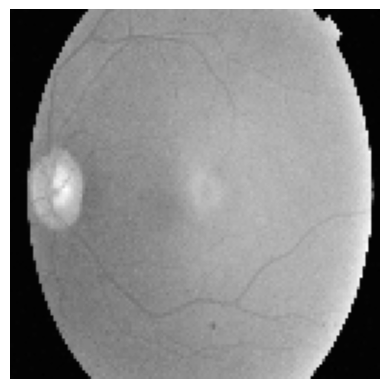

In [54]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Charger le modèle pré-entraîné
model = load_model("/kaggle/working/mon_modele128.h5")

# Chemin vers ton image
img_path = '/kaggle/input/aptos-mini/train_images/0024cdab0c1e.png'

# Charger l'image en niveaux de gris
img = image.load_img(img_path, target_size=(128, 128), color_mode='grayscale')

# Convertir l'image en tableau numpy
x = image.img_to_array(img)

# Ajouter une dimension pour le batch (le modèle attend une forme [batch_size, height, width, channels])
x = np.expand_dims(x, axis=0)

# Normaliser les pixels de l'image : valeurs entre 0 et 1
x = x / 255.0

# Vérifier la forme de l'entrée
print(f'Forme de l\'entrée de l\'image : {x.shape}')

# Effectuer l'inférence
predictions = model.predict(x)

# Afficher les résultats de la prédiction
print(f'Prédictions pour l\'image : {predictions[0]} ')

# Si tu veux aussi afficher l'image (optionnel)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()


In [59]:
# Afficher la structure du modèle pour comprendre ses couches
model.summary()

# Pour inspecter les couches du modèle, tu peux aussi utiliser :
for i, layer in enumerate(model.layers):
    print(f"[{i}] {layer.name} --- {layer.__class__.__name__}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,391 (28.20 MB)

 Trainable params: 7,392,389 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

[0] reshape --- Reshape
[1] conv2d --- Conv2D
[2] max_pooling2d --- MaxPooling2D
[3] conv2d_1 --- Conv2D
[4] max_pooling2d_1 --- MaxPooling2D
[5] flatten --- Flatten
[6] dense --- Dense
[7] dense_1 --- Dense


## 12- Visualisation GRADCAM 

In [48]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

# === 1. Prétraitement de l'image ===
def load_preprocess_image(img_path, size=(128, 128)):
    img = image.load_img(img_path, target_size=size)
    img_array = image.img_to_array(img)
    img_array_exp = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_exp), img

# === 2. Calcul du Grad-CAM ===
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# === 3. Superposition de la carte thermique ===
def overlay_heatmap(heatmap, image, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (image.size[0], image.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, colormap)
    image_np = np.array(image)
    superimposed_img = cv2.addWeighted(image_np, 1 - alpha, heatmap_color, alpha, 0)
    return superimposed_img

# === 4. Exécution ===
if __name__ == '__main__':
    model = MobileNetV2(weights='imagenet')
    last_conv_layer_name = 'Conv_1'

    img_path = '/kaggle/input/aptos2019-blindness-detection/train_images/000c1434d8d7.png'
    img_array, original_img = load_preprocess_image(img_path)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    cam_result = overlay_heatmap(heatmap, original_img)
    
    plt.imshow(cam_result)
    plt.axis('off')
    plt.title("Grad-CAM")
    plt.show()


14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


ValueError: Input 0 of layer "functional_33" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(1, 128, 128, 3)